In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forest-fires-data-set/forestfires.csv


In [2]:
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

The Fine Fuel Moisture Code (FFMC) represents fuel moisture of forest litter fuels under the shade of a forest canopy. It is intended to represent moisture conditions for shaded litter fuels, the equivalent of 16-hour timelag. It ranges from 0-101. Subtracting the FFMC value from 100 can provide an estimate for the equivalent (approximately 10h) fuel moisture content, most accurate when FFMC values are roughly above 80.

The Duff Moisture Code (DMC) represents fuel moisture of decomposed organic material underneath the litter. System designers suggest that it is represents moisture conditions for the equivalent of 15-day (or 360 hr) timelag fuels. It is unitless and open ended. It may provide insight to live fuel moisture stress.

The Drought Code (DC), much like the Keetch-Byrum Drought Index, represents drying deep into the soil. It approximates moisture conditions for the equivalent of 53-day (1272 hour) timelag fuels. It is unitless, with a maximum value of 1000. Extreme drought conditions have produced DC values near 800.

In [3]:
ff_dataset = pd.read_csv('../input/forest-fires-data-set/forestfires.csv')
ff_dataset

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [4]:
ff_dataset['area_log'] = np.where(ff_dataset['area'] ==  0, 0, np.log(ff_dataset['area']))
ff_dataset

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_log
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,1.862529
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,3.994340
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.412336
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000


In [5]:
only_negs = ff_dataset.loc[ff_dataset['area_log'] < 0]
only_negs

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_log
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36,-1.021651
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43,-0.843970
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47,-0.755023
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55,-0.597837
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61,-0.494296
143,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0.0,0.71,-0.342490
144,2,5,aug,wed,95.5,99.9,513.3,13.2,23.8,32,5.4,0.0,0.77,-0.261365
145,6,5,aug,thu,95.2,131.7,578.8,10.4,27.4,22,4.0,0.0,0.90,-0.105361
146,5,4,mar,mon,90.1,39.7,86.6,6.2,13.2,40,5.4,0.0,0.95,-0.051293
147,8,3,sep,tue,84.4,73.4,671.9,3.2,24.2,28,3.6,0.0,0.96,-0.040822


In [6]:
target_dataset = ff_dataset.drop(['month', 'day', 'X', 'Y', 'area'], axis=1)
target_dataset

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_log
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1.862529
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,3.994340
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.412336
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000


**Trying XGBoost**

In [7]:
# for xgboost
XTarget, yLabel = target_dataset.iloc[:,:-1],target_dataset.iloc[:,-1]
print(XTarget)
print(yLabel)

     FFMC    DMC     DC   ISI  temp  RH  wind  rain
0    86.2   26.2   94.3   5.1   8.2  51   6.7   0.0
1    90.6   35.4  669.1   6.7  18.0  33   0.9   0.0
2    90.6   43.7  686.9   6.7  14.6  33   1.3   0.0
3    91.7   33.3   77.5   9.0   8.3  97   4.0   0.2
4    89.3   51.3  102.2   9.6  11.4  99   1.8   0.0
..    ...    ...    ...   ...   ...  ..   ...   ...
512  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0
513  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0
514  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0
515  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0
516  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0

[517 rows x 8 columns]
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
512    1.862529
513    3.994340
514    2.412336
515    0.000000
516    0.000000
Name: area_log, Length: 517, dtype: float64


In [8]:
# for xgboost
data_dmatrix = xgb.DMatrix(data=XTarget,label=yLabel)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(XTarget, yLabel, test_size=0.2, random_state=123)

In [10]:
# using regressor since we are using regression against area
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [11]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)


[15:02:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [12]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1.337712


In [13]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[15:02:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [14]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.490281,0.068034,1.493283,0.141926
1,1.476116,0.065478,1.483648,0.141147
2,1.465246,0.063418,1.475488,0.140273
3,1.454482,0.061211,1.468689,0.139157
4,1.446317,0.060084,1.462654,0.137997


In [15]:
print((cv_results["test-rmse-mean"]).tail(1))

17    1.446565
Name: test-rmse-mean, dtype: float64


In [16]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[15:02:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


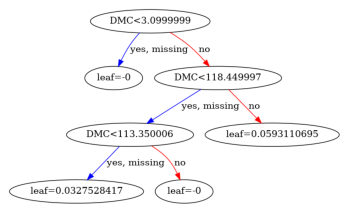

In [17]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

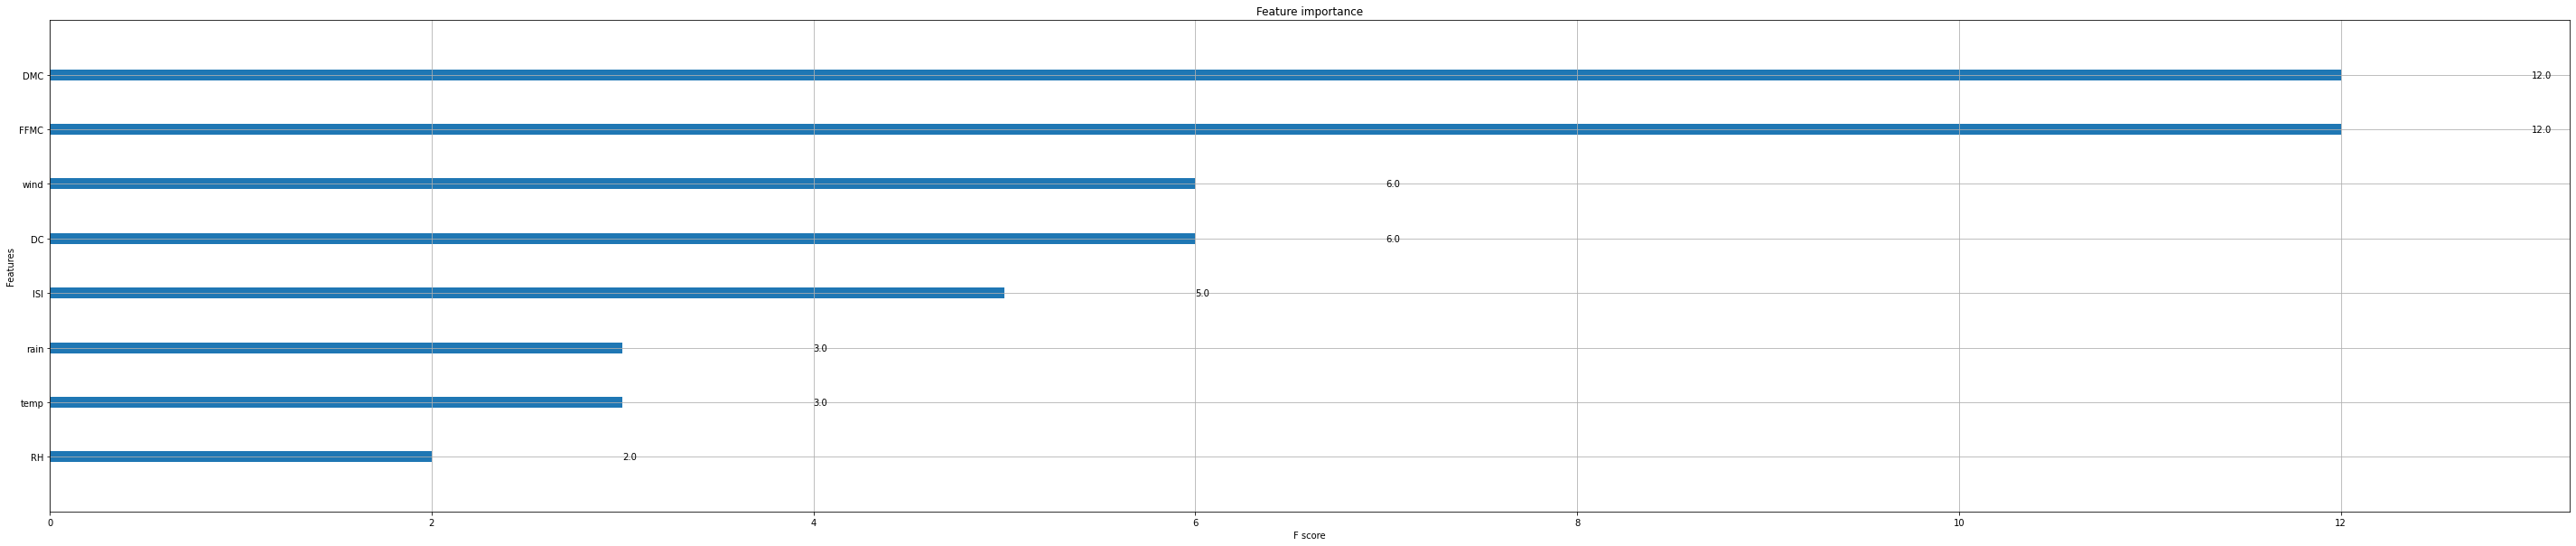

In [18]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

**End of XGBoost**

In [19]:
train_dataset = target_dataset.sample(frac=0.8, random_state=0)
test_dataset = target_dataset.drop(train_dataset.index)

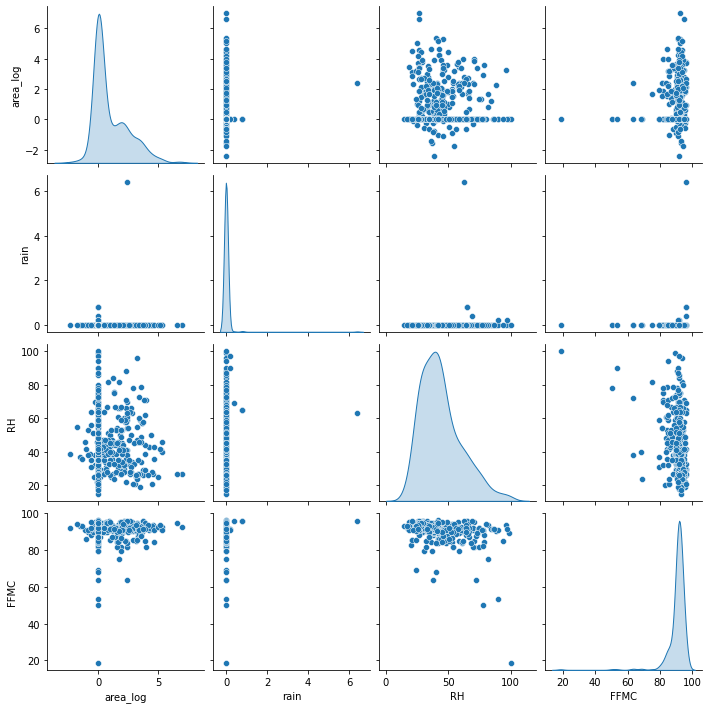

In [20]:
sns.pairplot(train_dataset[['area_log', 'rain', 'RH', 'FFMC']], diag_kind='kde')

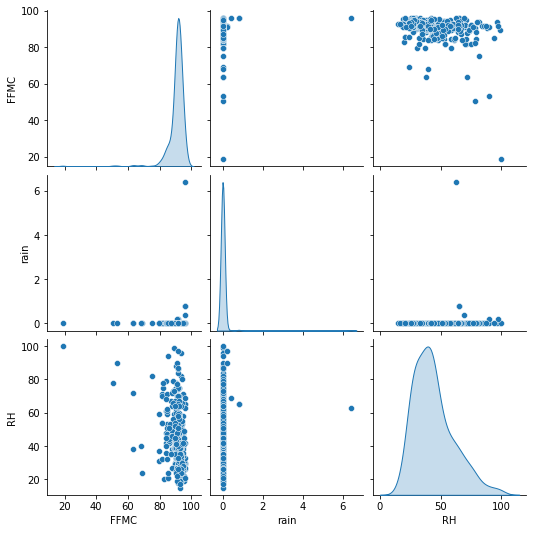

In [21]:
sns.pairplot(train_dataset[['FFMC', 'rain', 'RH']], diag_kind='kde')

In [22]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FFMC,414.0,90.534300,5.965789,18.700000,90.200,91.70,92.900000,96.200000
DMC,414.0,109.481643,62.796135,1.100000,70.800,108.00,141.200000,291.300000
DC,414.0,541.928986,251.496567,7.900000,425.775,663.00,709.100000,860.600000
ISI,414.0,9.136957,4.760950,0.000000,6.500,8.40,11.075000,56.100000
temp,414.0,18.800000,5.857786,2.200000,15.400,19.15,22.800000,33.300000
RH,414.0,44.142512,16.491291,15.000000,32.000,41.00,53.000000,100.000000
wind,414.0,3.967874,1.739613,0.400000,2.700,4.00,4.900000,9.400000
rain,414.0,0.021256,0.320007,0.000000,0.000,0.00,0.000000,6.400000
area_log,414.0,0.975136,1.461350,-2.407946,0.000,0.00,1.883655,6.994703


In [23]:
#train_dataset = train_dataset[train_dataset['area'] < 10]

array([[<AxesSubplot:title={'center':'area_log'}>]], dtype=object)

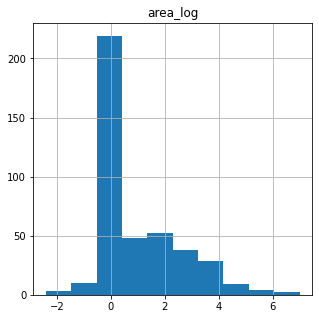

In [24]:
train_dataset.hist(column='area_log')

In [25]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('area_log')
test_labels = test_features.pop('area_log')

In [26]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
FFMC,90.534300,5.965789
DMC,109.481643,62.796135
DC,541.928986,251.496567
ISI,9.136957,4.760950
temp,18.800000,5.857786
RH,44.142512,16.491291
wind,3.967874,1.739613
rain,0.021256,0.320007
area_log,0.975136,1.461350


In [27]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [28]:
normalizer.adapt(np.array(train_features))

2022-09-07 15:02:27.689208: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-07 15:02:27.798029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [29]:
print(normalizer.mean.numpy())

[[9.0534309e+01 1.0948165e+02 5.4192896e+02 9.1369553e+00 1.8799999e+01
  4.4142506e+01 3.9678745e+00 2.1256037e-02]]


In [30]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 87.6  52.2 103.8   5.   11.   46.    5.8   0. ]]

Normalized: [[-0.49 -0.91 -1.74 -0.87 -1.33  0.11  1.05 -0.07]]


**Linear Regression**

In [31]:
dmc = np.array(train_features['DMC'])

dmc_normalizer = layers.Normalization(input_shape=[1,], axis=None)
dmc_normalizer.adapt(dmc)

In [32]:
dmc_model = tf.keras.Sequential([
    dmc_normalizer,
    layers.Dense(units=1)
])

dmc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [33]:
dmc_model.predict(dmc[:10])

array([[-0.15285839],
       [-0.06613085],
       [ 0.05502091],
       [ 0.06356023],
       [-0.05092015],
       [ 0.08464169],
       [-0.15846233],
       [ 0.08490855],
       [ 0.22580749],
       [-0.27080786]], dtype=float32)

In [34]:
dmc_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = dmc_model.fit(
    train_features['DMC'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 5.13 s, sys: 322 ms, total: 5.45 s
Wall time: 4.93 s


In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,1.104514,1.016465,95
96,1.085091,1.004590,96
97,1.088944,0.998450,97
98,1.095001,1.004203,98
99,1.090711,0.999134,99


In [37]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DMC]')
  plt.legend()
  plt.grid(True)

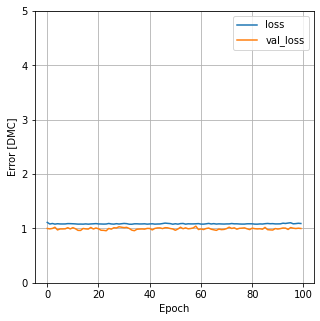

In [38]:
plot_loss(history)


In [39]:
test_results = {}

test_results['dmc_model'] = dmc_model.evaluate(
    test_features['DMC'],
    test_labels, verbose=0)

In [40]:
x = tf.linspace(0.0, 250, 251)
y = dmc_model.predict(x)

In [41]:
def plot_dmc(x, y):
  plt.scatter(train_features['DMC'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('DMC')
  plt.ylabel('area')
  plt.legend()

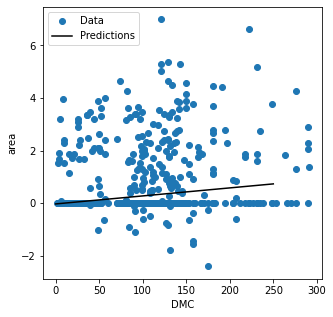

In [42]:
plot_dmc(x, y)


In [43]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [44]:
linear_model.predict(train_features[:10])

array([[-0.60989594],
       [-2.1299949 ],
       [ 0.87056214],
       [ 1.0290669 ],
       [-0.35988975],
       [ 1.5906293 ],
       [ 1.3234143 ],
       [-0.36027557],
       [-1.2533793 ],
       [-3.1171143 ]], dtype=float32)

In [45]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.43553555],
       [-0.32729292],
       [ 0.81164217],
       [ 0.4977399 ],
       [-0.25331283],
       [-0.3826222 ],
       [ 0.807217  ],
       [-0.12971622]], dtype=float32)>

In [46]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [47]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 5.15 s, sys: 292 ms, total: 5.44 s
Wall time: 5.02 s


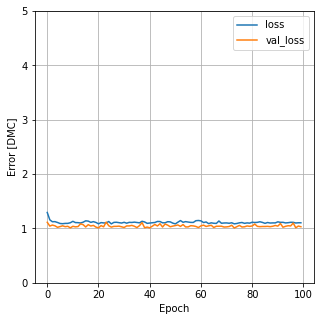

In [48]:
plot_loss(history)

In [49]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)


DNN

In [50]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [51]:
dnn_dmc_model = build_and_compile_model(dmc_normalizer)


In [52]:
dnn_dmc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [53]:
print(len(train_features))

414


In [54]:
%%time
history = dnn_dmc_model.fit(
    train_features['DMC'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.53 s, sys: 820 ms, total: 7.35 s
Wall time: 5.96 s


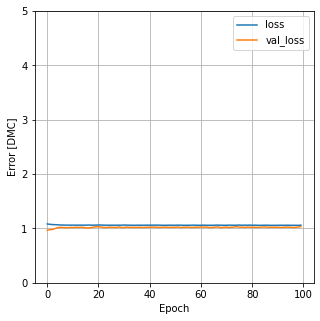

In [55]:
plot_loss(history)

In [56]:
x = tf.linspace(0.0, 50, 51)
y = dnn_dmc_model.predict(x)

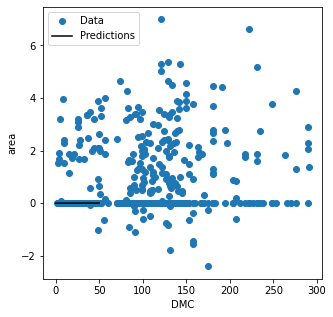

In [57]:
plot_dmc(x, y)

In [58]:
test_results['dnn_dmc_model'] = dnn_dmc_model.evaluate(
    test_features['DMC'], test_labels,
    verbose=0)

In [59]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [60]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 12.6 s, sys: 1.7 s, total: 14.3 s
Wall time: 11.3 s


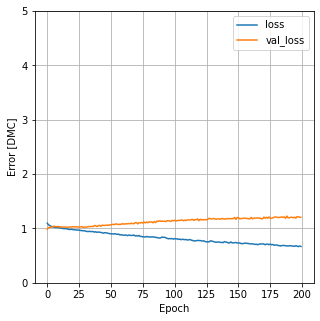

In [61]:
plot_loss(history)

In [62]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [63]:
pd.DataFrame(test_results, index=['Mean absolute error [area_log]']).T

,Mean absolute error [area_log]
dmc_model,1.001987
linear_model,1.027620
dnn_dmc_model,1.034191
dnn_model,1.149563
